# Benchmark Evaluation Script

## How to Run 

These are the high level tasks required to replicate the test scenario:

1. Start the devcontainer and wait for the container and the workspace to build. 
1. Ensure the `BUILD_BENCHMARK` flag in the `CMakeLists.txt` is `ON`; If change needed, rebuild workspace via `colcon build --symlink-install`.
1. Create a virtual python environment `python3 -m venv .venv`, activate it (`source .venv/bin/activate`) and install the requirements `pip install -r src/soar_ros/test/benchmark/requirements.txt`
1. Navigate to the `src/soar_ros/test/benchmark/` directory and run the `./benchmark.sh <channels>` script **as instructed below**.
1. Run this Jupyter Notebook to see the results.

## Explanation 

This is the evaluation script for the `soar_ros` benchmark. This benchmark compares three different scenarios:

1. `soar_ros` running without any messaging (no load)
2. `soar_ros` running in single input/ single output (SISO) mode
3. `soar_ros` running in multiple input/ multiple output (MIMO) mode

The _no load_ scenario is intended to capture the performance baseline on the
machine running the benchmark, so relative performance can be measured. 

The general usage of the script is:

```shell
./benchmark.sh <number_of_channels> 
```

**After each frequency, press `CTRL + C` to continue to the next frequency test!** 
Tests will be completed, once you only see the log message `[INFO]
[1766760154.788314964] [system]: Soar decision cycle executed`.

In order to run the tests on your machine, run the following commands on the terminal.

1. No Messaging:

    ```shell
    ./benchmark.sh 0
    ```

    **Special case:** Just stop the benchmark with `CTRL + C` after 5-10
    seconds. There is no need for testing multiple frequencies since the Soar
    kernel is running at maximum speed in any case.

2. SISO

    ```shell
    ./benchmark.sh 1
    ```

3. MIMO

    ```shell
    ./benchmark.sh 2
    ```

The tests save the logs and extracted data via the `parse-logs.py` script into
the `out/<timestamp>/` directory. In order for the following script to analyze
and compare the different test szenarios and results, set up the correct paths
in the next cell **based on your directory names**. The directory names are in
the following schema:

```shell
./out/<ISO8601 timestamp>_CHANNELS_<number_channels>/
```

Only the `<ISO8601 timestamp>_CHANNELS_<number_channels>` part is required for the 
directory names.

In [1]:
no_load_directory = "2025-12-30T17:31:24_CHANNELS_0" # results from ./benchmark.sh 0
siso_directory = "2025-12-30T18:06:52_CHANNELS_1" # results from ./benchmark.sh 1
mimo_directory = "2025-12-30T17:34:44_CHANNELS_2" # results from ./benchmark.sh 2

In [2]:
# general settings & imports
%matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

export_figures = False
plt.rcParams['axes.grid'] = True

In [3]:
# Distribution plot of decision cycle frequencies (No Load) using matplotlib
# Compute histograms and normalize to 100%
def compare_soar_kernel_frequencies(data_frames, labels):
    # Accepts a list of (df, label) tuples
    # colors = plt.cm.viridis(np.linspace(0, 1, len(data_frames)))
    plt.figure()
    for (idx, df) in enumerate(data_frames):
        freqs = 1 / df["timestamp"].diff().dropna()
        hist, bins = np.histogram(freqs, bins=50)
        hist = hist / hist.sum() * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.bar(bin_centers, hist, width=(bins[1]-bins[0]), alpha=0.5, label=labels[idx])
        print(f"{labels[idx]}: Mean = {freqs.mean():.2f} Hz, SD = {freqs.std():.2f} Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Count (%)")
    plt.title("Distribution of Soar Decision Cycle Frequencies")
    plt.legend()
    plt.show()

    # for (idx, df) in enumerate(data_frames):
    #     plt.figure()
    #     reset_idx = df["timestamp"].diff().reset_index(drop=True)
    #     plt.plot(1/reset_idx, marker='o', linestyle='', label=labels[idx], markersize=2)
    #     plt.ylabel("Frequency (Hz)")
    #     plt.xlabel("Soar Cycle (1)")
    #     plt.legend()
    #     plt.show()

def analyze_sender_frequency(df,show_plots=False):
    for freq in df["frequency"].unique():
        df_subset = df[(df["frequency"] == freq)]

        for channel in df_subset["channel"].unique():
            df_channel = df_subset[df_subset["channel"] == channel].sort_values("counter")
            # Reset the index so x-axis starts from 0 for each new plot
            mean = (1/df_channel["sender_time"].diff()).mean()
            sd = (1/df_channel["sender_time"].diff()).std()
            print(f"F {freq} Channel {channel} M: {mean:0.6} Hz, SD: {sd:0.6} Hz")

def plot_dual_axis_comparison(test_data, soar_data, frequency, title, figsize=(10, 6)):
    """
    Plot test data duration and Soar kernel frequency on aligned dual y-axes.
    
    Parameters:
    -----------
    test_data : pandas.DataFrame
        Test results dataframe with 'frequency', 'receive_time', and 'duration' columns
    soar_data : pandas.DataFrame
        Soar decision cycle dataframe with 'frequency' and 'timestamp' columns
    frequency : float
        Frequency to filter (e.g., 500.0)
    title : str
        Title for the plot
    figsize : tuple
        Figure size (width, height)
    """
    from matplotlib.ticker import MaxNLocator
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Data preparation
    df_test = test_data[test_data["frequency"] == frequency]
    df_soar = soar_data[soar_data["frequency"] == frequency]
    
    global_start = min(df_test["receive_time"].min(), df_soar["timestamp"].min())
    
    rel_receive_time = df_test["receive_time"] - global_start
    rel_timestamp = df_soar["timestamp"] - global_start
    freqs = 1 / df_soar["timestamp"].diff().dropna()
    
    min_time = min(rel_receive_time.min(), rel_timestamp.min())
    max_time = max(rel_receive_time.max(), rel_timestamp.max())
    
    # Left y-axis: Duration
    # color1 = 'tab:blue'
    ax1.set_xlabel("Relative Time (s)")
    ax1.set_ylabel("Duration (s)")

    for channel in df_test["channel"].unique():
        df_channel = df_test[df_test["channel"] == channel]
        ax1.plot(rel_receive_time[df_channel.index], df_channel["duration"], marker='o', linestyle='', markersize=2, label=f"Duration Channel {channel}")

    ax1.tick_params(axis='y')
    ax1.set_xlim(min_time, max_time)

    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel("Soar Kernel Frequency (Hz)", color=color2)
    ax2.plot(rel_timestamp[1:], freqs, marker='.', linestyle='', markersize=2, color=color2, label="Frequency",alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ylim1 = ax1.get_ylim()
    len1 = ylim1[1]-ylim1[0]
    yticks1 = ax1.get_yticks()
    rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
    ylim2 = ax2.get_ylim()
    len2 = ylim2[1]-ylim2[0]
    yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]

    #My best attempt
    ax2.set_yticks(yticks2)
    ax2.set_ylim(ylim2)  

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    fig.suptitle(title)
    # fig.tight_layout()
    ax2.grid(False)
    plt.show()


In [4]:
# Preloading all data for comparisons
# no_load df
base_path = os.path.join("out", no_load_directory,"data")
df_no_load = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

# SISO df
base_path = os.path.join("out", siso_directory,"data")
df_siso = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_siso_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

# MIMO df
base_path = os.path.join("out", mimo_directory,"data")
df_mimo = pd.read_csv(os.path.join(base_path,"combined_message_results.csv"))
df_mimo_soar = pd.read_csv(os.path.join(base_path,"combined_soar_decision.csv"))

## Scenario: No Load Analysis

No Load 125 Hz: Mean = 2168.14 Hz, SD = 999.06 Hz
No Load 250 Hz: Mean = 2457.37 Hz, SD = 1760.26 Hz
No Load 500 Hz: Mean = 2651.80 Hz, SD = 1978.39 Hz


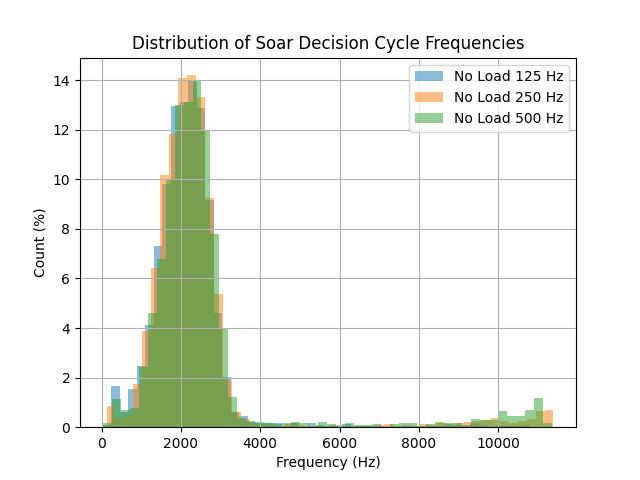

In [5]:
compare_soar_kernel_frequencies(
    [df_no_load[df_no_load["frequency"]==125.0], df_no_load[df_no_load["frequency"]==250.0], df_no_load[df_no_load["frequency"]==500.0]], ["No Load 125 Hz", "No Load 250 Hz", "No Load 500 Hz"])

As visible in the distribution diagram, the input frequency does not have an impact on the Soar kernel execution speed.

## Scenario: SISO Analysis

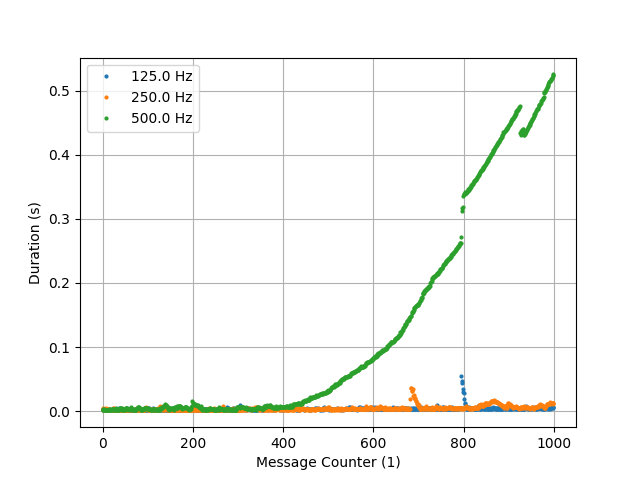

In [ ]:
plt.figure()
plt.xlabel('Message Counter (1)')
plt.ylabel('Duration (s)')

for frequencies in sorted(df_siso['frequency'].unique()):
    freq_df = df_siso[df_siso['frequency'] == frequencies]
    for channel in freq_df['channel'].unique():
        df_channel = freq_df[freq_df['channel'] == channel].sort_values(by='counter')
        plt.plot(df_channel['counter'], df_channel['duration'], marker='o', linestyle='', label=f'{frequencies} Hz',markersize=2)

plt.legend()
plt.show()

SISO 125 Hz: Mean = 1942.46 Hz, SD = 1044.92 Hz
SISO 250 Hz: Mean = 1908.14 Hz, SD = 1386.11 Hz
SISO 500 Hz: Mean = 1936.88 Hz, SD = 1459.82 Hz


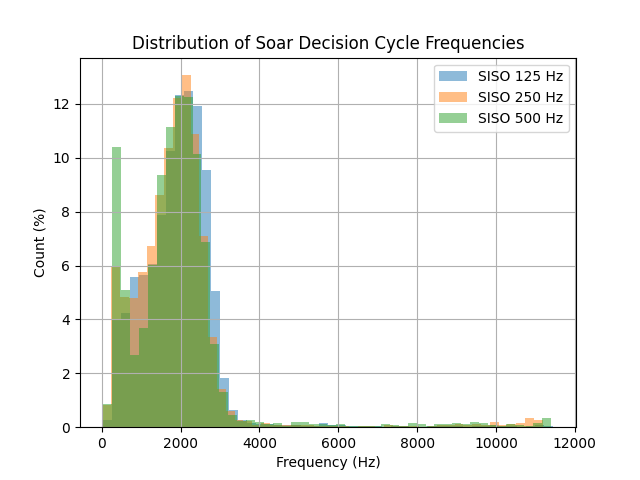

In [ ]:
compare_soar_kernel_frequencies(
    [df_siso_soar[df_siso_soar["frequency"]==125.0], df_siso_soar[df_siso_soar["frequency"]==250.0], df_siso_soar[df_siso_soar["frequency"]==500.0]],
    ["SISO 125 Hz", "SISO 250 Hz", "SISO 500 Hz"])

In [ ]:
analyze_sender_frequency(df_siso)

F 250.0 Channel 0 M: 252.022 Hz, SD: 36.3885 Hz
F 125.0 Channel 0 M: 125.306 Hz, SD: 8.477 Hz
F 500.0 Channel 0 M: 521.968 Hz, SD: 143.235 Hz


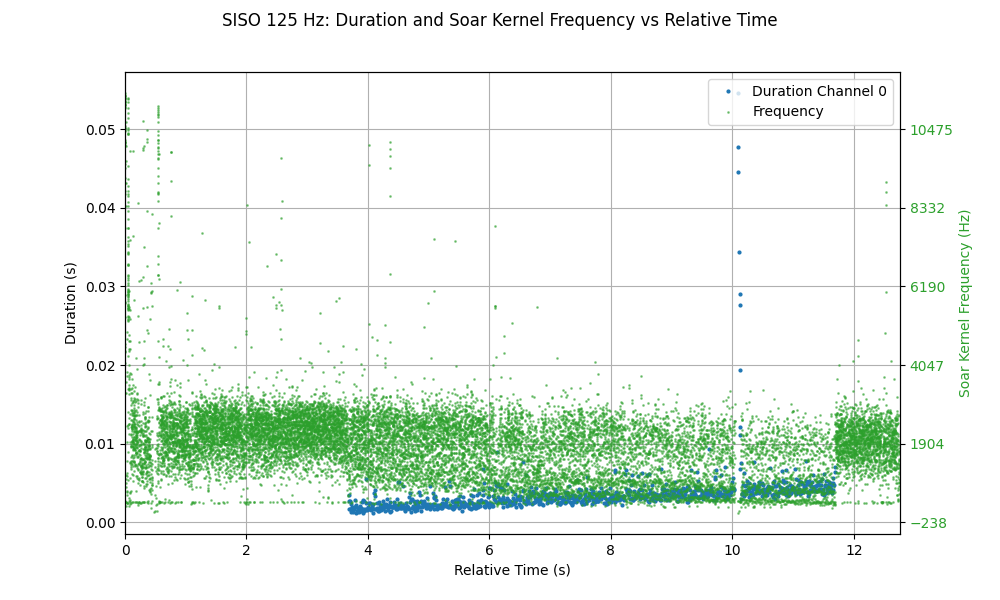

In [ ]:
plot_dual_axis_comparison(df_siso, df_siso_soar, 125.0, "SISO 125 Hz: Duration and Soar Kernel Frequency vs Relative Time")

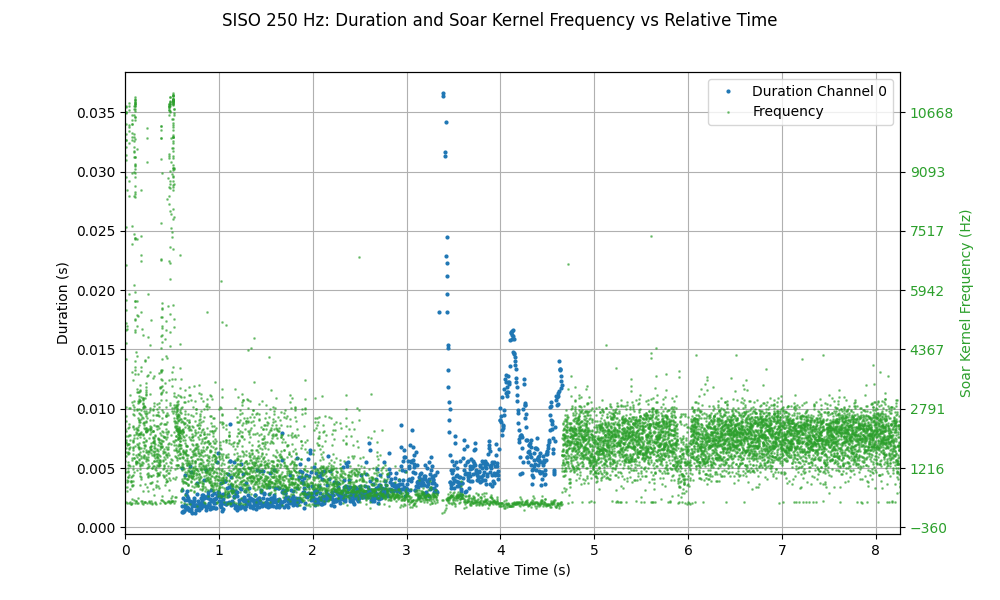

In [ ]:
plot_dual_axis_comparison(df_siso, df_siso_soar, 250.0, "SISO 250 Hz: Duration and Soar Kernel Frequency vs Relative Time")

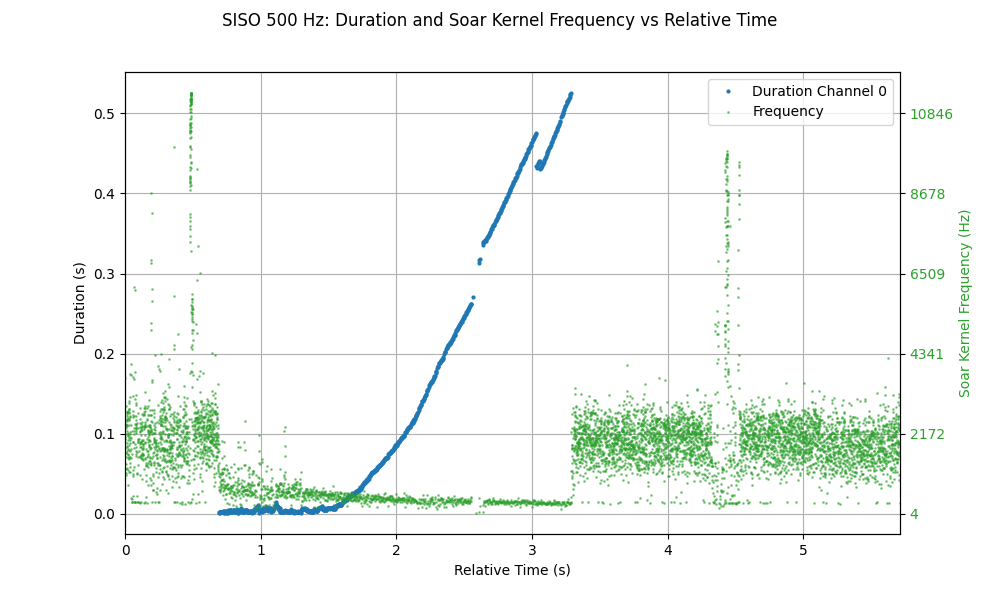

In [ ]:
plot_dual_axis_comparison(df_siso, df_siso_soar, 500.0, "SISO 500 Hz: Duration and Soar Kernel Frequency vs Relative Time")

## Scenario MIMO Analysis

MIMO 125 Hz: Mean = 1837.01 Hz, SD = 1672.80 Hz
MIMO 250 Hz: Mean = 1828.84 Hz, SD = 1198.73 Hz
MIMO 500 Hz: Mean = 1756.42 Hz, SD = 1079.43 Hz


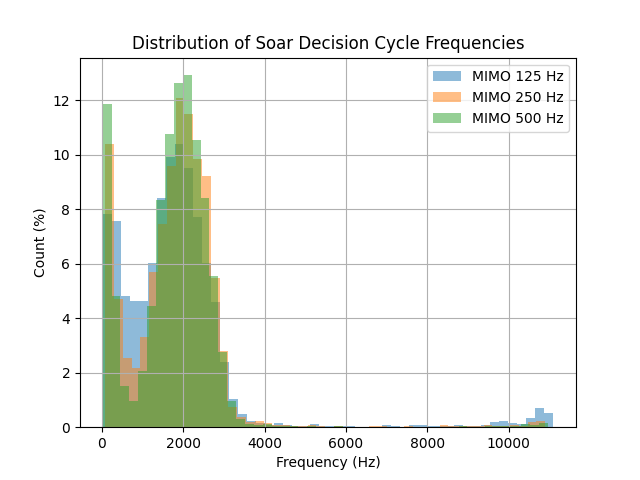

In [ ]:
compare_soar_kernel_frequencies(
    [df_mimo_soar[df_mimo_soar["frequency"]==125.0], df_mimo_soar[df_mimo_soar["frequency"]==250.0], df_mimo_soar[df_mimo_soar["frequency"]==500.0]],
    ["MIMO 125 Hz", "MIMO 250 Hz", "MIMO 500 Hz"])

In [ ]:
analyze_sender_frequency(df_mimo)

F 250.0 Channel 1 M: 254.962 Hz, SD: 38.2509 Hz
F 250.0 Channel 0 M: 254.807 Hz, SD: 37.9221 Hz
F 125.0 Channel 1 M: 125.492 Hz, SD: 14.1465 Hz
F 125.0 Channel 0 M: 125.272 Hz, SD: 9.85142 Hz
F 500.0 Channel 0 M: 512.624 Hz, SD: 141.673 Hz
F 500.0 Channel 1 M: 513.894 Hz, SD: 142.079 Hz


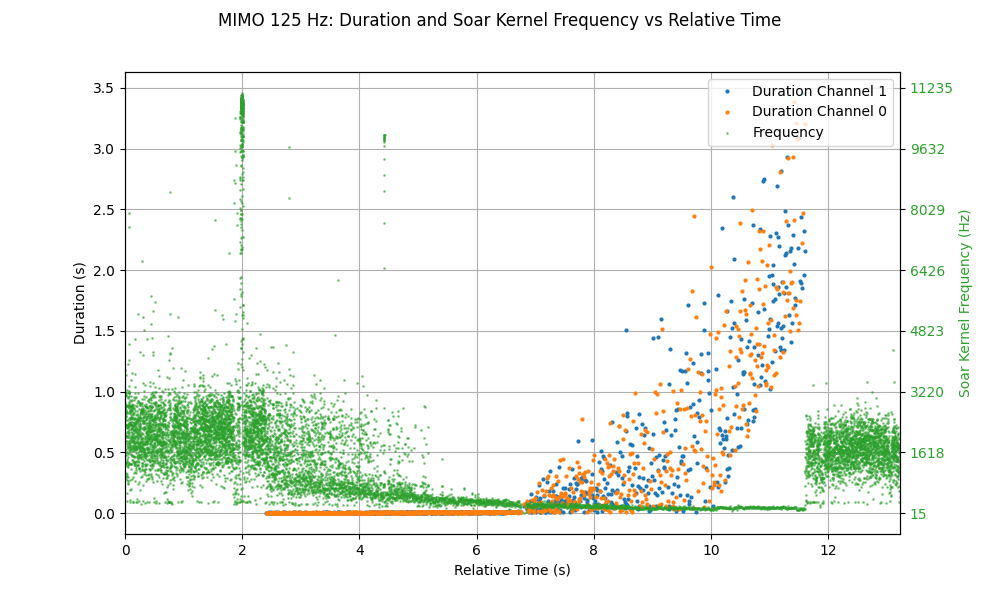

In [ ]:
plot_dual_axis_comparison(df_mimo, df_mimo_soar, 125.0, "MIMO 125 Hz: Duration and Soar Kernel Frequency vs Relative Time")

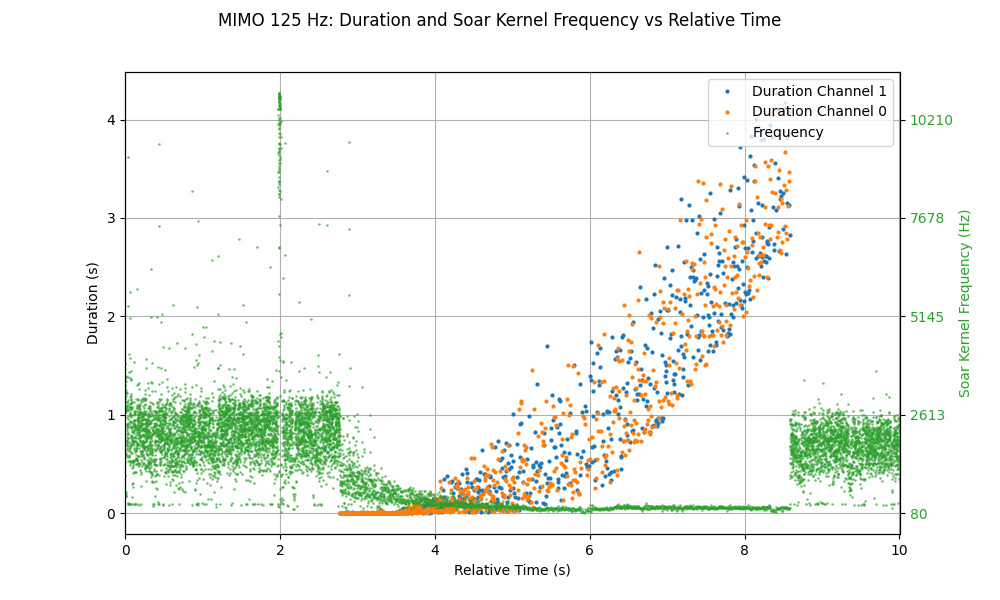

In [ ]:
plot_dual_axis_comparison(df_mimo, df_mimo_soar, 250.0, "MIMO 125 Hz: Duration and Soar Kernel Frequency vs Relative Time")

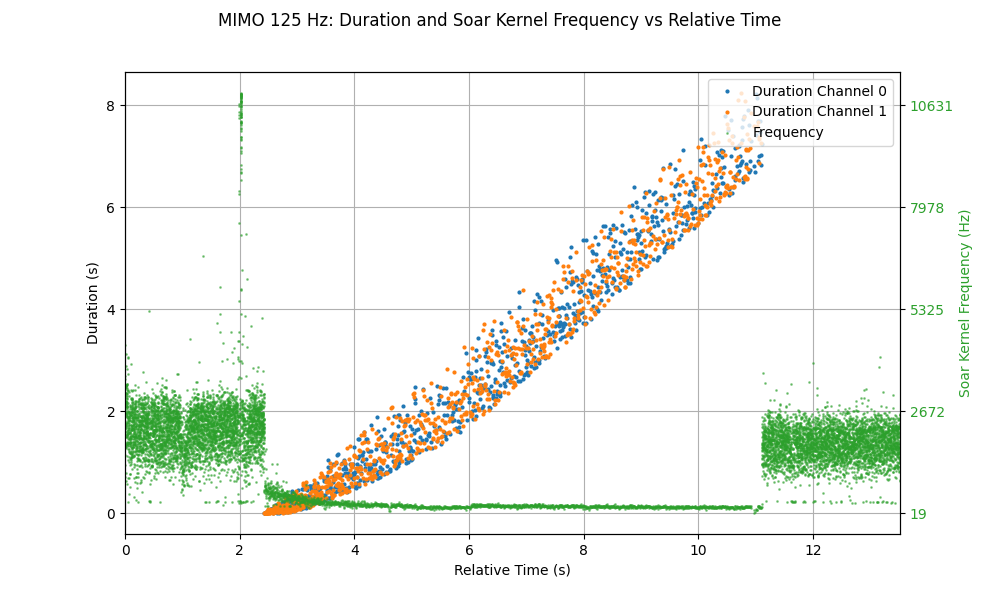

In [ ]:
plot_dual_axis_comparison(df_mimo, df_mimo_soar, 500.0, "MIMO 125 Hz: Duration and Soar Kernel Frequency vs Relative Time")

## Why do we see an increase in duration?

```log
1767116131.6864271 [System-2] [INFO] [1767116131.686303633] [system]: Soar decision cycle executed

1767116131.6873047 [Sender-3] [INFO] [1767116131.687083133] [sender]: Published to input: frame_id=135_0
1767116131.6873958 [Sender-3] [INFO] [1767116131.687101299] [sender]: Published to input: frame_id=135_1

1767116131.6875758 [System-2] [INFO] [1767116131.687149924] [system]: Sending on output1
1767116131.6876531 [System-2] [INFO] [1767116131.687211258] [system]: Received subscription msg on input1

1767116131.6877210 [Receiver-1] [INFO] [1767116131.687281674] [receiver]: Received on output: frame_id=106_1

1767116131.6877737 [System-2] [INFO] [1767116131.687299008] [system]: Received subscription msg on input0
1767116131.6886792 [System-2] [INFO] [1767116131.688557133] [system]: benchmark: 4907:    O: O5010 (add-frame-id-to-output1)
1767116131.6888061 [System-2] [INFO] [1767116131.688694424] [system]: Soar decision cycle executed
```

In one decision cycle, multiple intputs can be received but on the output link, only one o-supported item can be sent.

Possible future analysis: 

- [ ] Do a profiling analysis to see where the Soar kernel thread loses the most time? (Guess: parsing Soar to ROS messages)